In [1]:
%matplotlib inline
import matplotlib.pylab as plt

import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

C:\Users\Naveen\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### We'll continue with the air passengers data

In [2]:
air_passengers = pd.read_csv("data/AirPassengers.csv", header = 0, parse_dates = [0], names = ['Month', 'Passengers'], index_col = 0)

### We'll take the log to make variance more uniform & then difference
this is consistent with what we learned in Notebook 07 re: ACF

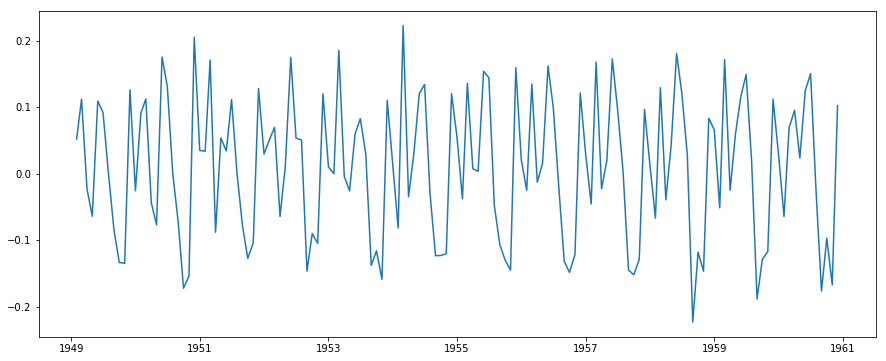

In [3]:
log_air_passengers = np.log(air_passengers.Passengers)
log_air_passengers_diff = log_air_passengers - log_air_passengers.shift()
plt.plot(log_air_passengers_diff)

In [4]:
log_air_passengers.head()

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
Name: Passengers, dtype: float64

In [5]:
log_air_passengers_diff.dropna(inplace=True)

In [ ]:
# Let's talk about the ARIMA model
# Auto-Regressive Integrated Moving Average
# In this case we're talking about a series with dependence among values (more natural)

In [ ]:
# Nothing but a linear regression with a few times
# 1. The number of Auto-Regressive Terms (p)
# 2. The number of Moving Average Terms (q)
# 3. The number of differences

In [6]:
# We don't pull these out of thin air, but rather draw them from the data
log_lag_acf = acf(log_air_passengers_diff.values, nlags = 36)
log_lag_pacf = pacf(log_air_passengers_diff.values, nlags = 36)

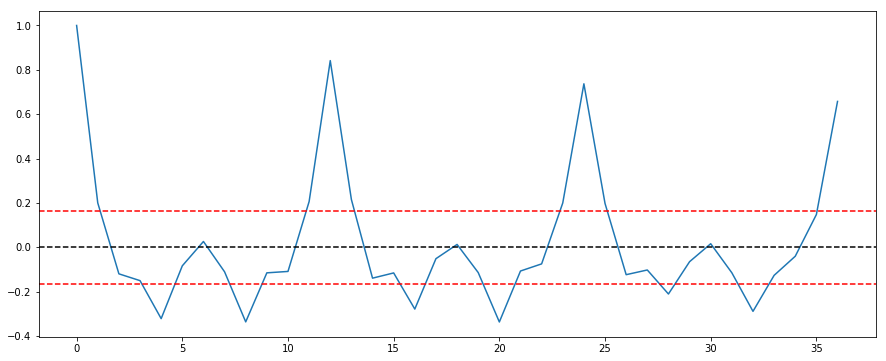

In [7]:
plt.plot(log_lag_acf)
plt.axhline(y=0,linestyle='--', color = 'black')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--', color = 'red')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--', color = 'red')

### Look at where the plot crosses the upper confidence interval for the first time in the ACF. This is 2 and gives us the MA parameter. For an MA process, the ACF drops off quickly.

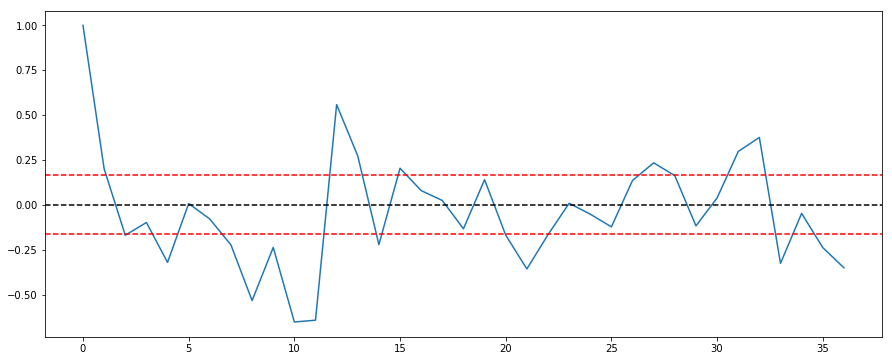

In [8]:
plt.plot(log_lag_pacf)
plt.axhline(y=0,linestyle='--', color = 'black')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--', color = 'red')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--', color = 'red')

### Look at where the plot crosses the upper confidence interval for the first time in the PACF. This is 2 and gives us the AR parameter. For an AR process the PACF drops off quickly while the ACF does not.

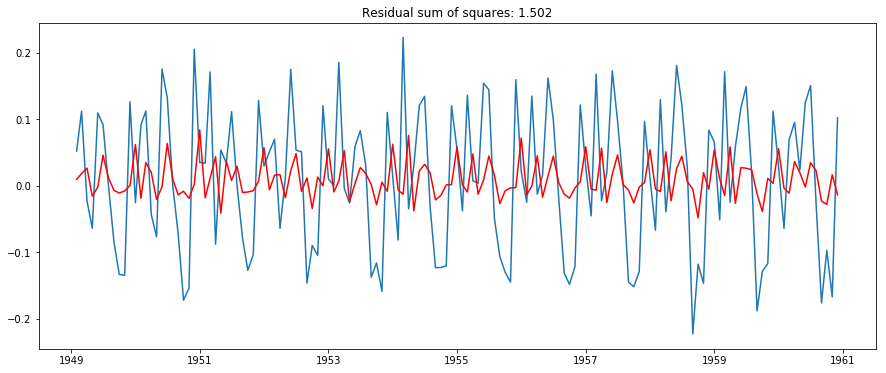

In [9]:
# AR model on differenced data
model = ARIMA(log_air_passengers, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('Residual sum of squares: %.3f'% sum((results_AR.fittedvalues-log_air_passengers_diff)**2))

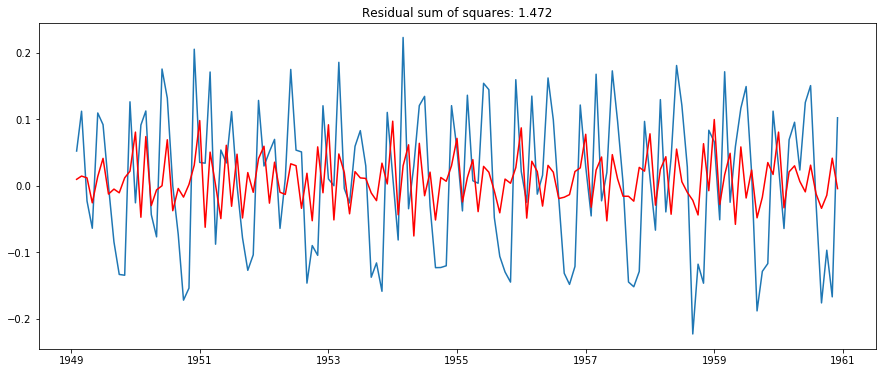

In [10]:
# MA model on differenced data
model = ARIMA(log_air_passengers, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('Residual sum of squares: %.3f'% sum((results_MA.fittedvalues-log_air_passengers_diff)**2))

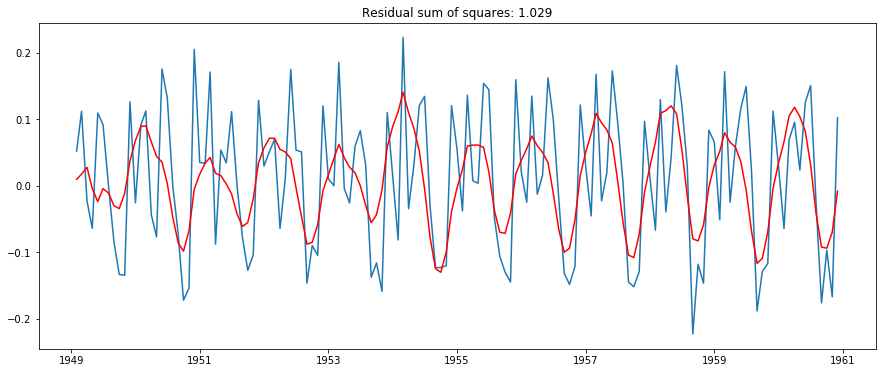

In [12]:
model = ARIMA(log_air_passengers, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('Residual sum of squares: %.3f'% sum((results_ARIMA.fittedvalues-log_air_passengers_diff)**2))

In [13]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)

In [14]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()

In [16]:
predictions_ARIMA_log = pd.Series(log_air_passengers.iloc[0], index=log_air_passengers.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

predictions_MA_log = pd.Series(log_air_passengers.iloc[0], index=log_air_passengers.index)
predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum,fill_value=0)


predictions_AR_log = pd.Series(log_air_passengers.iloc[0], index=log_air_passengers.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum,fill_value=0)


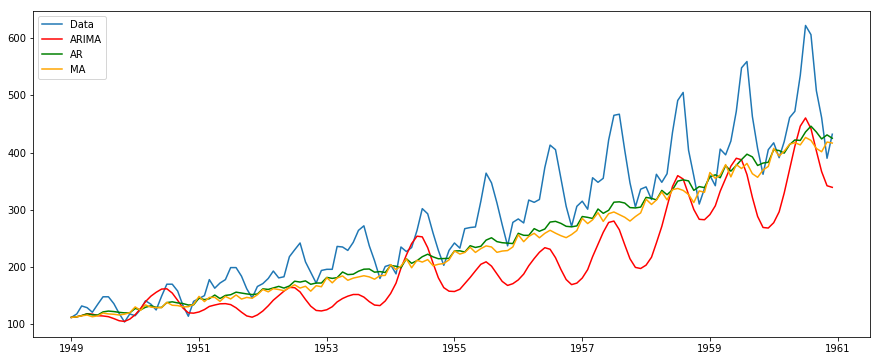

In [17]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
predictions_AR = np.exp(predictions_AR_log)
predictions_MA = np.exp(predictions_MA_log)
air1, = plt.plot(air_passengers)
arima, = plt.plot(predictions_ARIMA, color = 'red')
ar, = plt.plot(predictions_AR, color = 'green')
ma, = plt.plot(predictions_MA, color = 'orange')
plt.legend([air1, arima, ar, ma], ['Data', 'ARIMA', 'AR', 'MA'])

### Try again without including all data

In [20]:
model_test = ARIMA(log_air_passengers[:-12], order=(2, 1, 2))  
results_ARIMA_test = model_test.fit(disp=-1)  

predictions_ARIMA_diff_test = pd.Series(results_ARIMA_test.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum_test = predictions_ARIMA_diff_test.cumsum()
predictions_ARIMA_log_test = pd.Series(log_air_passengers.iloc[0], index=log_air_passengers.index)
predictions_ARIMA_log_test = predictions_ARIMA_log_test.add(predictions_ARIMA_diff_cumsum_test,fill_value=0)
predictions_ARIMA_test = np.exp(predictions_ARIMA_log_test)



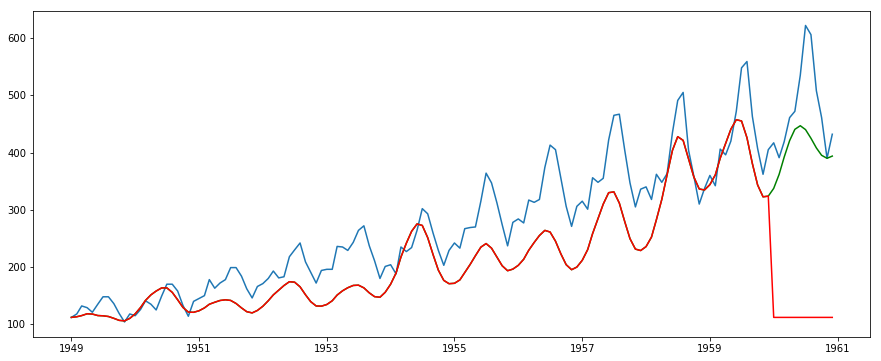

In [21]:
model = ARIMA(log_air_passengers[:-12], order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  

predictions_ARIMA_diff = results_ARIMA.predict(end = len(log_air_passengers) - 1)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(log_air_passengers.iloc[0], index=log_air_passengers.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA2 = np.exp(predictions_ARIMA_log)

air1, = plt.plot(air_passengers)
arima2, = plt.plot(predictions_ARIMA2, color = 'green')
arima1, = plt.plot(predictions_ARIMA_test, color = 'red')